# **Hyperparameter Optimisation**

## Objectives

* To perform hyperparameter optimisation for GradientBoostingClassifier and RandomForestClassifier algorithms, and model the reduced, 20 variable dataset

## Inputs

* The data file, "US_Accidents_For_ML.csv", which is saved locally in "Data/ML"

## Outputs

* The best performing model and pipeline

## Summary of Steps

* Load the dataset
* Reduce the dataset to the chosen 20 variables
* Split the dataset into train and test sets
* 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Accidents_ML_Project\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\sonia\\Documents\\VS Studio Projects\\US_Accidents_ML_Project'

---

## Required Libraries

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [286]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [226]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 

---

## Load the Dataset

I will load the dataset using Pandas.

In [6]:
df = pd.read_csv("Data/ML/US_Accidents_For_ML.csv")
pd.set_option("display.max_columns", None)
df.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Timezone,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Clearance_Class,Weather_Simplified,State_Other,Population,County_Other,Month
0,2,32.456486,-93.774536,0.501,Central,78.0,62.0,29.61,10.0,CALM,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,Night,Very Long,Fair,LA,187540,Caddo,Sep
1,2,36.804693,-76.189728,0.253,Eastern,54.0,90.0,30.40,7.0,CALM,0.0,0.0,False,False,True,False,False,False,False,False,False,False,True,Night,Very Long,Fair,VA,459444,Virginia Beach,May
2,2,29.895741,-90.090026,1.154,Pacific,40.0,58.0,30.28,10.0,N,10.0,0.0,False,False,False,False,True,False,False,False,False,False,False,Day,Very Long,Cloudy,LA,440784,Jefferson,Jan
3,2,32.456459,-93.779709,0.016,Central,62.0,75.0,29.80,10.0,SSE,8.0,0.0,False,False,False,False,False,False,False,False,False,False,False,Night,Very Long,Cloudy,LA,187540,Caddo,Nov
4,2,26.966433,-82.255414,0.057,Eastern,84.0,69.0,29.99,10.0,E,18.0,0.0,False,False,False,False,False,False,False,False,False,False,False,Day,Very Long,Cloudy,FL,186824,Other,Sep


---

## Reduce Dataset to 20 Variables

As in the previous notebook, I will reduce to the dataset to varaibles that showed statistically significant differences in either clearance classes or clearance time.

In [7]:
keep_col = [
    "Severity",
    "Distance(mi)",
    "Timezone",
    "Temperature(F)",
    "Humidity(%)",
    "Pressure(in)",
    "Visibility(mi)",
    "Wind_Direction",
    "Wind_Speed(mph)",
    "Precipitation(in)",
    "Station",
    "Stop",
    "Traffic_Signal",
    "Sunrise_Sunset",
    "Clearance_Class",
    "Weather_Simplified",
    "State_Other",
    "Population",
    "County_Other",
    "Month"
]

df_keep = df[keep_col].copy()
df_keep.head()

,Severity,Distance(mi),Timezone,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Station,Stop,Traffic_Signal,Sunrise_Sunset,Clearance_Class,Weather_Simplified,State_Other,Population,County_Other,Month
0,2,0.501,Central,78.0,62.0,29.61,10.0,CALM,0.0,0.0,False,False,False,Night,Very Long,Fair,LA,187540,Caddo,Sep
1,2,0.253,Eastern,54.0,90.0,30.40,7.0,CALM,0.0,0.0,False,False,True,Night,Very Long,Fair,VA,459444,Virginia Beach,May
2,2,1.154,Pacific,40.0,58.0,30.28,10.0,N,10.0,0.0,False,False,False,Day,Very Long,Cloudy,LA,440784,Jefferson,Jan
3,2,0.016,Central,62.0,75.0,29.80,10.0,SSE,8.0,0.0,False,False,False,Night,Very Long,Cloudy,LA,187540,Caddo,Nov
4,2,0.057,Eastern,84.0,69.0,29.99,10.0,E,18.0,0.0,False,False,False,Day,Very Long,Cloudy,FL,186824,Other,Sep


---

# Split into Train and Test

I split the data into train and test sets.

In [8]:
mapping = {'Short': 0, 'Moderate': 1, 'Long': 2, "Very Long": 3}
df_keep['Clearance_Class_num'] = df_keep['Clearance_Class'].map(mapping)

X_train, X_test, y_train, y_test = train_test_split(
    df_keep.drop(['Clearance_Class', "Clearance_Class_num"], axis=1),
    df_keep['Clearance_Class_num'],
    test_size=0.2,
    random_state=0
)
print(
    "* Train set:",
    X_train.shape,
    y_train.shape,
    "\n* Test set:",
    X_test.shape,
    y_test.shape,
)

* Train set: (7968, 19) (7968,) 
* Test set: (1992, 19) (1992,)


---

## Gradient Boosting Classifier

Steps to be included in the preprocessor step:

- Encoding categorical variables
- Scaling numerical variables

Steps to be included in the pipeline:
- Preprocessor
- Feature selection
- Model selection 

In [162]:
def PipelineOptimization(model, X):
    numeric_cols = X.select_dtypes(include="number").columns.tolist()
    categorical_cols = X.select_dtypes(include="object").columns.tolist()

    numeric_pipeline = Pipeline([
        ("scaler", StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ("numeric", numeric_pipeline, numeric_cols),
        ("categorical", categorical_pipeline, categorical_cols)
    ])

    steps = [("preprocessor", preprocessor)]

    # Add feature selection if the model supports it
    if hasattr(model, "coef_") or hasattr(model, "feature_importances_"):
        steps.append(("feat_selection", SelectFromModel(model)))

    steps.append(("model", model))

    pipeline = Pipeline(steps)
    return pipeline

GradientBoostingClassifier is the only algorithm this time.

In [322]:
models_search = {
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
}

Below are the different hyperparameters that I will use to tune the model. The goal of tuning is to find a balance between bias and variance.

- Bias is when the model ails to capture important relationships i.e. underfitting; it shows as low training and test accuracies
- Variance measures how a model’s predictions change on different subsets of the data. High variance means to model captured noise in the training data and generalises poorly i.e. overfitting; it shows as high training accuracy but much lower test accuracy 

I chosen to tune the following hyperparameters which are likely to impact accuracy scores:

- learning_rate - Controls how much each tree contributes to correcting the errors of the previous ensemble; low values take more time, but these small adjustments tend to reduce overfitting
- n_estimators - The number of boosting stages trees to fit; too little, the model stops learning too early, leading to underfitting (high bias); too many reduces training error but but fits noise, can lead to overfitting (high variance) 
- max_depth - Controls how complex each individual tree is; low values mean it can learn simple patterns only, leading to good generalisation, but could underfit; high value means it can learn complex patterns between features, it will fit the training data better but could overfit 
- min_samples_split - Minimum samples (rows) needed to split a node; larger values means simpler trees and potentially underfitting; smaller values mean complex tress and possible overfitting
- min_samples_leaf - Minimum samples (rows) per leaf (terminal branch); too high mean less detail and potentially underfitting; too low means a highly detailed model which could be overfitted 
- subsample - Controls how much of the training data each tree is allowed to see, 1 = 100 %; introduces randomness which reduces variance but can increases bias

Note, I have tried various combinations and these are the final parameters that I am testing.

In [323]:
params_search = {
    "GradientBoostingClassifier": {
        "model__learning_rate": [0.05],
        "model__n_estimators": [100],
        "model__max_depth": [7],
        "model__min_samples_split": [5, 10],
        "model__min_samples_leaf": [10, 20],
        "model__subsample": [0.8],
    }
}

In [165]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = list(models.keys())
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model_pipeline = PipelineOptimization(self.models[key], X)
            params = self.params[key]
            gs = GridSearchCV(model_pipeline, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, refit=True)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            gs = self.grid_searches[k]
            params = gs.cv_results_['params']
            all_scores = gs.cv_results_['mean_test_score']
            for p, s in zip(params, all_scores):
                rows.append(row(k, [s], p))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns += [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

I fit each model to the data.

In [324]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(
    X_train, y_train,
    scoring='f1_macro',
    n_jobs=-1,
    cv=2,
    refit=True
)


Running GridSearchCV for GradientBoostingClassifier 

Fitting 2 folds for each of 4 candidates, totalling 8 fits


Then output a summary table to see the performance of each model.

In [325]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__subsample
0,GradientBoostingClassifier,0.591897,0.591897,0.591897,0.0,0.05,7,10,5,100,0.8
1,GradientBoostingClassifier,0.591897,0.591897,0.591897,0.0,0.05,7,10,10,100,0.8
2,GradientBoostingClassifier,0.589863,0.589863,0.589863,0.0,0.05,7,20,5,100,0.8
3,GradientBoostingClassifier,0.589863,0.589863,0.589863,0.0,0.05,7,20,10,100,0.8


## Fit the Best Performing Model to the Data

I grab the best model, which here, of course, will be GradientBoostingClassifier.

In [326]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingClassifier'

I also grab the best hyperparameters.

In [327]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.05,
 'model__max_depth': 7,
 'model__min_samples_leaf': 10,
 'model__min_samples_split': 5,
 'model__n_estimators': 100,
 'model__subsample': 0.8}

Then set the final model with best model and hyperparameters.

In [328]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Evaluate the Model

This function produces a confusion matrix, which shows the number of actual values for each class against the number of predicted values, and the classification report, which describes how the model performed using different metrics.

In [329]:
def confusion_matrix_and_report(X, y, pipeline, label_order):
    prediction = pipeline.predict(X)

    # Map class names to consistent label order
    labels = list(range(len(label_order)))
    label_names = label_order

    # --- Confusion Matrix ---
    cm = confusion_matrix(y, prediction, labels=labels)
    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(
        cm,
        columns=[f"Predicted {name}" for name in label_names],
        index=[f"Actual {name}" for name in label_names]
    ))
    print("\n")

    # --- Classification Report ---
    print('---  Classification Report  ---')
    print(classification_report(y, prediction, labels=labels, target_names=label_names))
    print("\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_order):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_order)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_order)


Here, I run an instance of the function above to generate the confusion matrix and performance report for the model fitted.

In [330]:
label_order = ['Short', 'Moderate', 'Long', 'Very Long']

clf_performance(
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test, 
    y_test=y_test,
    pipeline=best_pipeline,
    label_order=label_order
)

#### Train Set #### 

---  Confusion Matrix  ---
                  Predicted Short  Predicted Moderate  Predicted Long  \
Actual Short                 1682                 163             240   
Actual Moderate               425                1221             415   
Actual Long                    97                 194            1719   
Actual Very Long               21                 149             230   

                  Predicted Very Long  
Actual Short                       31  
Actual Moderate                    64  
Actual Long                        82  
Actual Very Long                 1235  


---  Classification Report  ---
              precision    recall  f1-score   support

       Short       0.76      0.79      0.77      2116
    Moderate       0.71      0.57      0.63      2125
        Long       0.66      0.82      0.73      2092
   Very Long       0.87      0.76      0.81      1635

    accuracy                           0.74      7968
   macro avg       0.75  

At the top is the confusion matrix and performance report for the train set, and below is the same for the test set. The performance metrics are:
- precision: of those that were predicted to belong to a class, what proportion were correct 

    = True Positive/ (True Positive + False Positive)
- recall: of those that actually belong to a class, what proportion were predicted correctly 

    = True Positive/ (True Positive + True Negative)
- f1-score: is the hormonic mean of precision and recall - combined metric
- support: how many samples/ rows belog to that class
- accuracy: overall proportion of correct predictions
- macro avg: average of each metric across all classes
- weighted avg: average of each metric weighted by class frequency  

**Overall Performance**

Train set accuracy: 0.79

Test set accuracy: 0.62

Macro-average F1-score: 0.79 (train) vs 0.62 (test)

The model does reasonably well on the training data but shows a drop on the test data, suggesting moderate overfitting. The drop is not extreme, so it has learned some generalisable patterns.

**Class-wise Performance**

Looking at precision, recall, and F1-score per class:

Short - Recall slightly drops on test; some misclassification into other classes.
Moderate - Model struggles to identify “Short” correctly. Likely overlapping features.
Long - Reasonable performance; recall still good on test.
Very Long - Best-performing class; predictions are more reliable.

“Moderate” and "Long" are the hardest classes to distinguish, possibly because their feature distributions overlap.

“Short” and “Very Long” are predicted more reliably.

**Bias vs Variance**

Train F1-score > Test F1-score across almost all classes → some overfitting (variance is moderate).

Test F1-score ~0.62 macro → model generalizes reasonably but could benefit from more data or feature engineering.

**Summary Description**

The final model is a RandomForestClassifier tuned to reduce variance. It achieves decent performance, especially on “Long” and “Very Long” clearance times, but struggles with intermediate classes (“Short” and “Moderate”). There’s moderate overfitting as shown by the higher training scores compared to the test set. Overall, the model captures general patterns in the data, with room for improvement in distinguishing classes that are close together.

## Important Features


* Top 20 grouped features:

           Feature  Importance
      Distance(mi)    0.321164
       State_Other    0.193858
      County_Other    0.100111
        Population    0.073278
      Pressure(in)    0.066685
    Temperature(F)    0.047413
          Severity    0.037013
       Humidity(%)    0.036261
             Month    0.027671
          Timezone    0.024409
   Wind_Speed(mph)    0.024068
    Wind_Direction    0.013949
    Sunrise_Sunset    0.013476
Weather_Simplified    0.010009
    Visibility(mi)    0.006200
 Precipitation(in)    0.004435


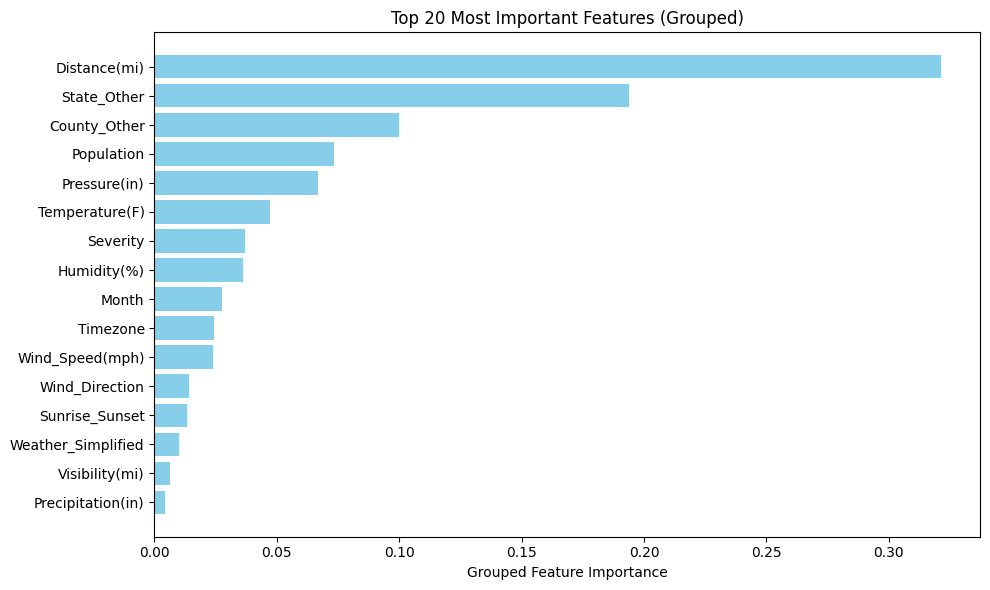

In [331]:
preprocessor = best_pipeline.named_steps['preprocessor']

all_feature_names = []

for name, transformer, cols in preprocessor.transformers_:
    if name == 'categorical':
        # Get OHE feature names
        ohe = transformer.named_steps['onehot']
        ohe_names = ohe.get_feature_names_out(cols)
        all_feature_names.extend(ohe_names)
    else:
        # numeric transformer
        all_feature_names.extend(cols)

# Sometimes ColumnTransformer adds a 'remainder' with dropped columns
if hasattr(preprocessor, 'remainder') and preprocessor.remainder != 'drop':
    remainder_cols = [c for c in X_train.columns if c not in sum([list(t[2]) for t in preprocessor.transformers_], [])]
    all_feature_names.extend(remainder_cols)

# Get model importances
importances = best_pipeline.named_steps['model'].feature_importances_

# Group by original column
grouped_importance = {}
for f, imp in zip(all_feature_names, importances):
    col_found = False
    for cat_col in preprocessor.transformers_[1][2]:  # categorical columns
        if f.startswith(cat_col + "_"):
            col = cat_col
            col_found = True
            break
    if not col_found:
        col = f
    grouped_importance[col] = grouped_importance.get(col, 0) + imp

df_grouped = pd.DataFrame({
    "Feature": list(grouped_importance.keys()),
    "Importance": list(grouped_importance.values())
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

# Top 20 print
top_n = 20
print(f"\n* Top {top_n} grouped features:\n")
print(df_grouped.head(top_n).to_string(index=False))

# Top 20 plot
plt.figure(figsize=(10,6))
plt.barh(df_grouped.head(top_n)["Feature"][::-1], 
         df_grouped.head(top_n)["Importance"][::-1], 
         color="skyblue")
plt.xlabel("Grouped Feature Importance")
plt.title(f"Top {top_n} Most Important Features (Grouped)")
plt.tight_layout()
plt.show()

---

## Random Forest Classifier

In [242]:
def PipelineOptimization(model, X):
    numeric_cols = X.select_dtypes(include="number").columns.tolist()
    categorical_cols = X.select_dtypes(include="object").columns.tolist()

    numeric_pipeline = Pipeline([
        ("scaler", StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ("numeric", numeric_pipeline, numeric_cols),
        ("categorical", categorical_pipeline, categorical_cols)
    ])

    steps = [("preprocessor", preprocessor)]

    # Add feature selection if the model supports it
    if hasattr(model, "coef_") or hasattr(model, "feature_importances_"):
        steps.append(("feat_selection", SelectFromModel(model)))

    steps.append(("model", model))

    pipeline = Pipeline(steps)
    return pipeline

In [243]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
}

For this algorithm, I am tuning the following hyperparameters:
- n_estimators - Number of trees in the forest; too few → underfitting (high bias); too many → slower, diminishing returns
- max_depth -How deep each tree can grow; shallow trees underfit; deep trees can overfit
- min_samples_split - Minimum samples (rows) needed to split a node; larger values → simpler trees → less overfitting
- min_samples_leaf - Minimum samples (rows) per leaf (terminal branch); higher values → smooth predictions, reduce variance
- max_features - How many features are considered at each split; Smaller → more random, less correlated trees → less overfitting

In [ ]:
params_search = {
    "RandomForestClassifier": {
        'model__n_estimators': [600],
        'model__max_depth': [30],
        'model__min_samples_split': [10],
        'model__min_samples_leaf': [10],             
        'model__max_features': ['sqrt', 0.5],  
        }
}

In [245]:
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = list(models.keys())
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model_pipeline = PipelineOptimization(self.models[key], X)
            params = self.params[key]
            gs = GridSearchCV(model_pipeline, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring, refit=True)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, score, params):
            d = {
                'estimator': key,
                'min_score': score,
                'max_score': score,
                'mean_score': score,
                'std_score': 0.0
            }
            # Merge hyperparameters
            return pd.Series({**d, **params})

        rows = []
        for k in self.grid_searches:
            gs = self.grid_searches[k]
            params_list = gs.cv_results_['params']
            scores = gs.cv_results_['mean_test_score']
            for p, s in zip(params_list, scores):
                rows.append(row(k, s, p))

        df = pd.DataFrame(rows)
        # Sort and order columns
        base_cols = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        other_cols = [c for c in df.columns if c not in base_cols]
        df = df[base_cols + other_cols].sort_values(sort_by, ascending=False)
        return df, self.grid_searches


In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(
    X_train, y_train,
    scoring='accuracy',
    n_jobs=-1,
    cv=2,
    refit=True
)


Running GridSearchCV for RandomForestClassifier 

Fitting 2 folds for each of 2 candidates, totalling 4 fits


In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
1,RandomForestClassifier,0.586847,0.586847,0.586847,0.0,30,0.5,10,10,600
0,RandomForestClassifier,0.566140,0.566140,0.566140,0.0,30,sqrt,10,10,600


Now I can grab the best performing model.

In [248]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

Followed by the best performing hyperparameters.

In [ ]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 30,
 'model__max_features': 0.5,
 'model__min_samples_leaf': 10,
 'model__min_samples_split': 10,
 'model__n_estimators': 600}

Then set the final pipeline with these parameters in place.

In [250]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Pipeline Evaluation

In [251]:
def confusion_matrix_and_report(X, y, pipeline, label_order):
    prediction = pipeline.predict(X)

    # Map class names to consistent label order
    labels = list(range(len(label_order)))
    label_names = label_order

    # --- Confusion Matrix ---
    cm = confusion_matrix(y, prediction, labels=labels)
    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(
        cm,
        columns=[f"Predicted {name}" for name in label_names],
        index=[f"Actual {name}" for name in label_names]
    ))
    print("\n")

    # --- Classification Report ---
    print('---  Classification Report  ---')
    print(classification_report(y, prediction, labels=labels, target_names=label_names))
    print("\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_order):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_order)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_order)

In [ ]:
label_order = ['Short', 'Moderate', 'Long', 'Very Long']

clf_performance(
    X_train=X_train, 
    y_train=y_train,
    X_test=X_test, 
    y_test=y_test,
    pipeline=best_pipeline,
    label_order=label_order
)

#### Train Set #### 

---  Confusion Matrix  ---
                  Predicted Short  Predicted Moderate  Predicted Long  \
Actual Short                 1692                 167             212   
Actual Moderate               456                1261             320   
Actual Long                    92                 182            1728   
Actual Very Long               29                 198             225   

                  Predicted Very Long  
Actual Short                       45  
Actual Moderate                    88  
Actual Long                        90  
Actual Very Long                 1183  


---  Classification Report  ---
              precision    recall  f1-score   support

       Short       0.75      0.80      0.77      2116
    Moderate       0.70      0.59      0.64      2125
        Long       0.70      0.83      0.76      2092
   Very Long       0.84      0.72      0.78      1635

    accuracy                           0.74      7968
   macro avg       0.74  

Model Assessment – RandomForestClassifier

Train macro avg F1 ≈ 0.8, Test macro avg F1 ≈ 0.59
→ Indicates moderate variance — some overfitting, but the model generalizes reasonably well.

Overall accuracy: ~59% on the test set across 4 classes.
This is much higher than random chance (25%), showing the model captures real signal.

Class performance:

Short and Long classes perform best (F1 ≈ 0.6–0.7).

Moderate remains hardest to classify (F1 ≈ 0.38) — likely due to overlap with adjacent classes.

Very Long shows strong precision and recall (0.74/0.67), meaning the model identifies most of these correctly with few false positives.

Interpretation:
The model effectively distinguishes extremes (Short vs. Very Long), but intermediate classes (Moderate, Long) are harder to separate — likely reflecting overlapping patterns in the underlying features.

Summary (2–3 sentences)

The final RandomForestClassifier achieved a test accuracy of 59% (macro F1 = 0.59), indicating moderate predictive power across the four clearance time classes. It performs best on the Short and Very Long categories, with more confusion between the Moderate and Long classes. Overall, the model generalizes fairly well, balancing bias and variance given the complexity of the task.

## Most Important Features

Now, I will look at the most important features that contribute to the model.


* Top 20 grouped features:

           Feature  Importance
      Distance(mi)    0.325273
       State_Other    0.167496
        Population    0.078298
      County_Other    0.076703
      Pressure(in)    0.070330
    Temperature(F)    0.057042
       Humidity(%)    0.049760
          Timezone    0.037071
          Severity    0.036331
   Wind_Speed(mph)    0.031354
             Month    0.023335
    Sunrise_Sunset    0.014689
Weather_Simplified    0.013827
    Wind_Direction    0.009296
    Visibility(mi)    0.006603
 Precipitation(in)    0.002594


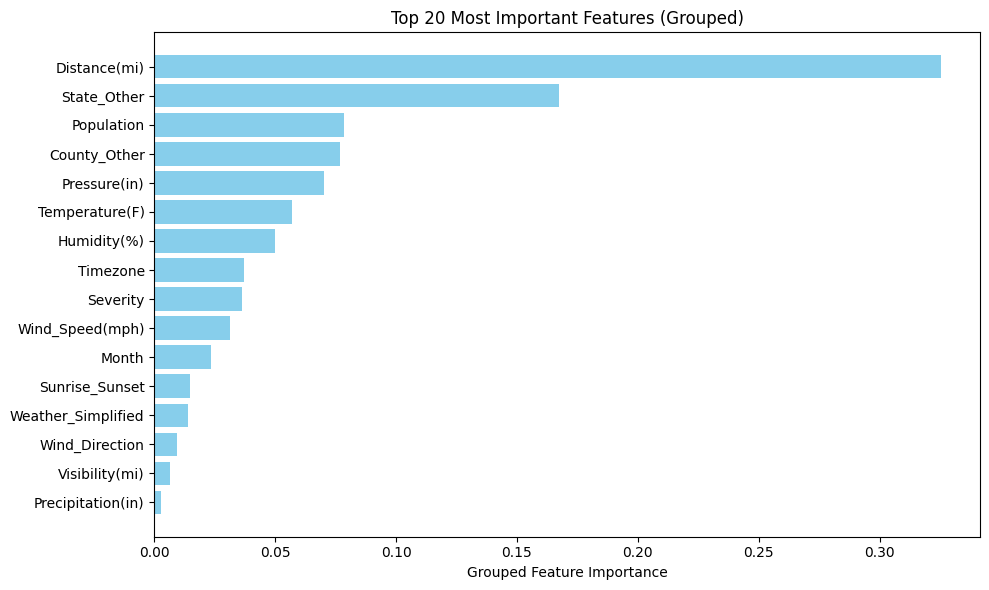

In [ ]:
preprocessor = best_pipeline.named_steps['preprocessor']

all_feature_names = []

for name, transformer, cols in preprocessor.transformers_:
    if name == 'categorical':
        # Get OHE feature names
        ohe = transformer.named_steps['onehot']
        ohe_names = ohe.get_feature_names_out(cols)
        all_feature_names.extend(ohe_names)
    else:
        # numeric transformer
        all_feature_names.extend(cols)

# Sometimes ColumnTransformer adds a 'remainder' with dropped columns
if hasattr(preprocessor, 'remainder') and preprocessor.remainder != 'drop':
    remainder_cols = [c for c in X_train.columns if c not in sum([list(t[2]) for t in preprocessor.transformers_], [])]
    all_feature_names.extend(remainder_cols)

# Get model importances
importances = best_pipeline.named_steps['model'].feature_importances_

# Group by original column
grouped_importance = {}
for f, imp in zip(all_feature_names, importances):
    col_found = False
    for cat_col in preprocessor.transformers_[1][2]:  # categorical columns
        if f.startswith(cat_col + "_"):
            col = cat_col
            col_found = True
            break
    if not col_found:
        col = f
    grouped_importance[col] = grouped_importance.get(col, 0) + imp

df_grouped = pd.DataFrame({
    "Feature": list(grouped_importance.keys()),
    "Importance": list(grouped_importance.values())
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

# Top 20 print
top_n = 20
print(f"\n* Top {top_n} grouped features:\n")
print(df_grouped.head(top_n).to_string(index=False))

# Top 20 plot
plt.figure(figsize=(10,6))
plt.barh(df_grouped.head(top_n)["Feature"][::-1], 
         df_grouped.head(top_n)["Importance"][::-1], 
         color="skyblue")
plt.xlabel("Grouped Feature Importance")
plt.title(f"Top {top_n} Most Important Features (Grouped)")
plt.tight_layout()
plt.show()

---

## Conclusion

---